In [472]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import models, datasets
import torch.optim as optim
import os
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pylab as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import shutil


from IPython.display import Image
from PIL import Image as imgus

# merge все .csv файлы

In [473]:
main_df = pd.read_csv('letters.csv')
main_df.drop('background', axis=1, inplace=True)

for i in range(len(main_df)):
    main_df.loc[i, 'file'] = os.path.join('letters', main_df.loc[i, 'file'])

for root in ['letters2', 'letters3']:
    tmp_df = pd.read_csv(root + '.csv')
    tmp_df.drop('background', axis=1, inplace=True)
    for i in range(len(tmp_df)):
        tmp_df.loc[i, 'file'] = os.path.join(root, tmp_df.loc[i, 'file'])
    main_df = main_df.merge(tmp_df, how='outer')
    
main_df = shuffle(main_df)
main_df.head()

,letter,label,file
9198,х,23,letters2/23_218.png
7791,т,20,letters2/20_101.png
2782,ж,8,letters2/08_72.png
7667,с,19,letters3/19_358.png
1965,д,5,letters3/05_246.png


In [474]:
#узнали все буквы и создали name_of_letters для создания нового датафрейма
letters = ''.join(sorted(main_df.letter.unique()))
name_of_letters = ['filename']
for letter in letters:
    name_of_letters.append(letter)

In [476]:
main_df

,letter,label,file
9198,х,23,letters2/23_218.png
7791,т,20,letters2/20_101.png
2782,ж,8,letters2/08_72.png
7667,с,19,letters3/19_358.png
1965,д,5,letters3/05_246.png
...,...,...,...
10262,ч,25,letters3/25_373.png
9463,ц,24,letters/24_04.png
10876,щ,27,letters2/27_176.png
6826,п,17,letters3/17_377.png


In [477]:
# One-hot encoding для label
a = []
for row in main_df.itertuples():
    t = [row.file]
    for i in range(1, len(letters) + 1):
        if i == row.label:
            t.append(1.)
        else:
            t.append(0.)
    a.append(t)

In [479]:
# создали новый датафрейм
main_df = shuffle(pd.DataFrame(a, columns = name_of_letters))
main_df.head()

,filename,а,б,в,г,д,е,ж,з,и,...,ч,ш,щ,ъ,ы,ь,э,ю,я,ё
4534,letters2/27_208.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10723,letters3/14_262.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3624,letters/21_19.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10306,letters2/21_88.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9645,letters2/32_224.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [480]:
classnames = [i for i in letters]

In [481]:
# создали 2 папки, которые хранят train и valid
for Class in classnames:
    for phase in ['train', 'valid']:
        os.makedirs(os.path.join(phase, Class))

In [482]:
train_df, valid_df = train_test_split(main_df,
                               test_size=0.15,
                               random_state=42)

In [483]:
# перемещение изображений в папки train, valid
for index, row in train_df.iterrows():
    for bukv in classnames:
        if row[bukv]:
            shutil.copy(os.path.join(row['filename']), os.path.join('train', bukv))

for index, row in valid_df.iterrows():
    for bukv in classnames:
        if row[bukv]:
            shutil.copy(os.path.join(row['filename']), os.path.join('valid', bukv))

# Обучим 4 разные модели

ResNet18_Architecture


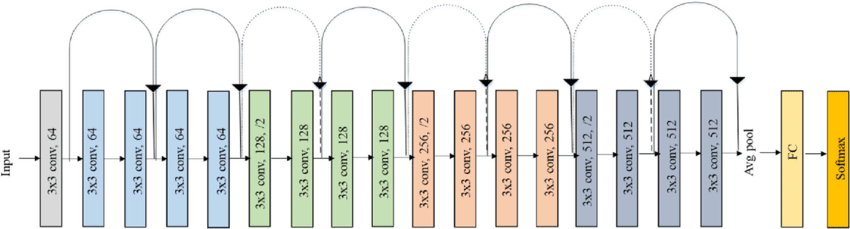

In [468]:
print('ResNet18_Architecture')
Image("ResNet18_Architecture.png", width=10000, height=1040)

DenseNet121_Architecture


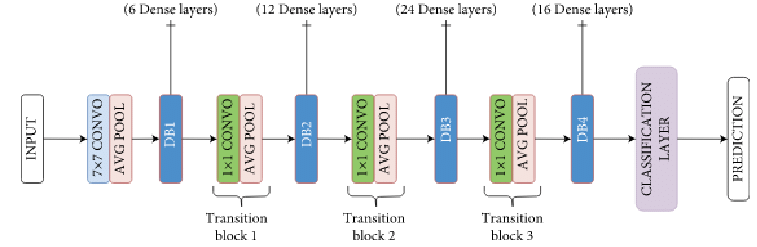

In [469]:
print('DenseNet121_Architecture')
Image("DenseNet121_Architecture.png", width=10000, height=1040)

MobileNetV2_Architecture


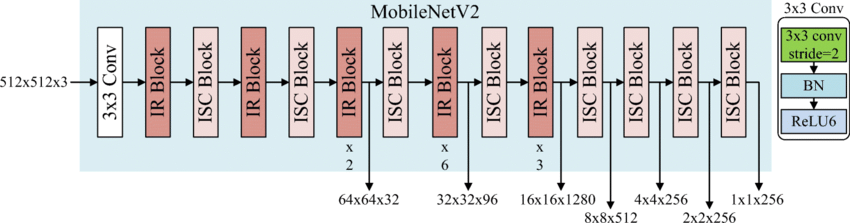

In [470]:
print('MobileNetV2_Architecture')
Image("MobileNetV2_Architecture.png", width=10000, height=1040)

In [491]:
# Параметры DataLoader'ов
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]),
    'valid':
    transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train':
    datasets.ImageFolder(os.path.join('train'), data_transforms['train']),
    
    'valid':
    datasets.ImageFolder(os.path.join('valid'), data_transforms['valid'])
}

dataloaders = {
    'train':
    DataLoader(image_datasets['train'],
              batch_size=16,
              shuffle=True,
              num_workers=0),
    
    'valid':
    DataLoader(image_datasets['valid'],
              batch_size=16,
              shuffle=True,
              num_workers=0)
}

# Размеры датасетов
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

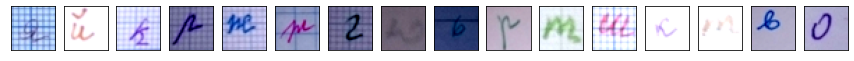

In [513]:
# Функция для отображения изображений из DataLoader
def show_images(dataloader, classnames, num_images=5):
    images, labels = next(iter(dataloader))
    images = images.numpy()

    images = images / 2 + 0.5
    images = np.clip(images, 0, 1)
    batch_size = len(images)

    fig, axes = plt.subplots(1, batch_size, figsize=(15, 3))
    for i in range(batch_size):
        axes[i].imshow(np.transpose(images[i], (1, 2, 0)))

        axes[i].set_xticks([])
        axes[i].set_yticks([])
    plt.show()

show_images(dataloaders['train'], classnames)

In [492]:
# Обучение модели
def train_model(model, criterion, optimizer, num_epochs=10):
    best_f1 = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / dataset_sizes['train']

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Подсчитываем f1_score
        f1 = evaluate_model(model)
        print(f"F1 Score: {f1:.4f}")

        # Сохраняем модель с лучшим f1_score
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'best_model.pth')

    print("Training complete.")
    return best_f1

# Оценка модели
def evaluate_model(model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='macro')
    return f1

# Функция инициализации весов модели Xavier Glorot initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

In [501]:
# Сеть 1: Простая сверточная нейронная сеть
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, len(classnames))

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 32 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ResNet18
resnet = models.resnet18(pretrained=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(classnames))
resnet.apply(weights_init)
resnet.to(device)

# DenseNet121
densenet = models.densenet121(pretrained=False)
num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs, len(classnames))
densenet.apply(weights_init)
densenet.to(device)

# MobileNetV2
mobilenet = models.mobilenet_v2(pretrained=False)
num_ftrs = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Linear(num_ftrs, len(classnames))
mobilenet.apply(weights_init)
mobilenet.to(device)

# Определение критерия и оптимизатора для каждой модели
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet.parameters(), lr=0.001)
optimizer_densenet = optim.Adam(densenet.parameters(), lr=0.001)
optimizer_mobilenet = optim.Adam(mobilenet.parameters(), lr=0.001)

/home/filichkin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/filichkin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Обучение каждой модели и оценка их производительности

In [502]:
print("Обучение моей CNN...")
simple_cnn = MyCNN().to(device)
simple_cnn.apply(weights_init)
optimizer_simple_cnn = optim.Adam(simple_cnn.parameters(), lr=0.001)
best_f1_simple_cnn = train_model(simple_cnn, criterion, optimizer_simple_cnn)

Обучение моей CNN...
Epoch 1/10, Loss: 2.4390
F1 Score: 0.5453
Epoch 2/10, Loss: 1.2787
F1 Score: 0.6818
Epoch 3/10, Loss: 0.8173
F1 Score: 0.7390
Epoch 4/10, Loss: 0.5976
F1 Score: 0.7777
Epoch 5/10, Loss: 0.4693
F1 Score: 0.7919
Epoch 6/10, Loss: 0.3650
F1 Score: 0.7947
Epoch 7/10, Loss: 0.2842
F1 Score: 0.8048
Epoch 8/10, Loss: 0.2245
F1 Score: 0.8094
Epoch 9/10, Loss: 0.1853
F1 Score: 0.8052
Epoch 10/10, Loss: 0.1458
F1 Score: 0.8068
Training complete.


In [495]:
print("Обучение ResNet18...")
best_f1_resnet = train_model(resnet, criterion, optimizer_resnet)

Обучение ResNet18...
Epoch 1/10, Loss: 2.9808
F1 Score: 0.3651
Epoch 2/10, Loss: 1.5540
F1 Score: 0.6575
Epoch 3/10, Loss: 0.9092
F1 Score: 0.7472
Epoch 4/10, Loss: 0.6603
F1 Score: 0.8092
Epoch 5/10, Loss: 0.5267
F1 Score: 0.8371
Epoch 6/10, Loss: 0.4317
F1 Score: 0.8584
Epoch 7/10, Loss: 0.3561
F1 Score: 0.8712
Epoch 8/10, Loss: 0.3282
F1 Score: 0.8691
Epoch 9/10, Loss: 0.3044
F1 Score: 0.8602
Epoch 10/10, Loss: 0.2665
F1 Score: 0.8577
Training complete.


In [496]:
print("Обучение DenseNet121...")
best_f1_densenet = train_model(densenet, criterion, optimizer_densenet)

Обучение DenseNet121...
Epoch 1/10, Loss: 3.4350
F1 Score: 0.0389
Epoch 2/10, Loss: 2.5960
F1 Score: 0.4426
Epoch 3/10, Loss: 1.4485
F1 Score: 0.6669
Epoch 4/10, Loss: 0.8898
F1 Score: 0.7119
Epoch 5/10, Loss: 0.6504
F1 Score: 0.8258
Epoch 6/10, Loss: 0.6107
F1 Score: 0.7991
Epoch 7/10, Loss: 0.4293
F1 Score: 0.8371
Epoch 8/10, Loss: 0.3834
F1 Score: 0.8437
Epoch 9/10, Loss: 0.3156
F1 Score: 0.8851
Epoch 10/10, Loss: 0.2460
F1 Score: 0.8851
Training complete.


In [497]:
print("Обучение MobileNetV2...")
best_f1_mobilenet = train_model(mobilenet, criterion, optimizer_mobilenet)

Обучение MobileNetV2...
Epoch 1/10, Loss: 3.7164
F1 Score: 0.0601
Epoch 2/10, Loss: 3.2648
F1 Score: 0.1100
Epoch 3/10, Loss: 3.0008
F1 Score: 0.1609
Epoch 4/10, Loss: 2.6814
F1 Score: 0.3056
Epoch 5/10, Loss: 2.3936
F1 Score: 0.3341
Epoch 6/10, Loss: 2.2587
F1 Score: 0.3794
Epoch 7/10, Loss: 1.9640
F1 Score: 0.4744
Epoch 8/10, Loss: 1.7571
F1 Score: 0.5573
Epoch 9/10, Loss: 1.5957
F1 Score: 0.4894
Epoch 10/10, Loss: 1.4180
F1 Score: 0.6255
Training complete.


In [508]:
# Вывод результатов
print(f"Лучшие результаты f1_score, которые показали модели:\nMyCNN - {best_f1_simple_cnn}\nResNet18 - {best_f1_resnet}")
print(f'DenseNet121 - {best_f1_densenet}\nMobileNetV2 - {best_f1_mobilenet}')

Лучшие результаты f1_score, которые показали модели:
MyCNN - 0.8094226444217009
ResNet18 - 0.8712417861233892
DenseNet121 - 0.8850935009633695
MobileNetV2 - 0.6255127405806763


Лучшие результаты на данном датасете по f1_score получила DenseNet121